In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

2025-07-26 15:38:51.391370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753544331.583430      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753544331.645932      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [3]:
# Read in the data
DATA_DIR = '/kaggle/input/histopathologic-cancer-detection/'
labels_df = pd.read_csv(DATA_DIR + 'train_labels.csv')

TRAIN_DIR = os.path.join(DATA_DIR, 'train') # Contains training images


# Show basic info
print(f"Total labeled images: {len(labels_df)}")
labels_df.head()

Total labeled images: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


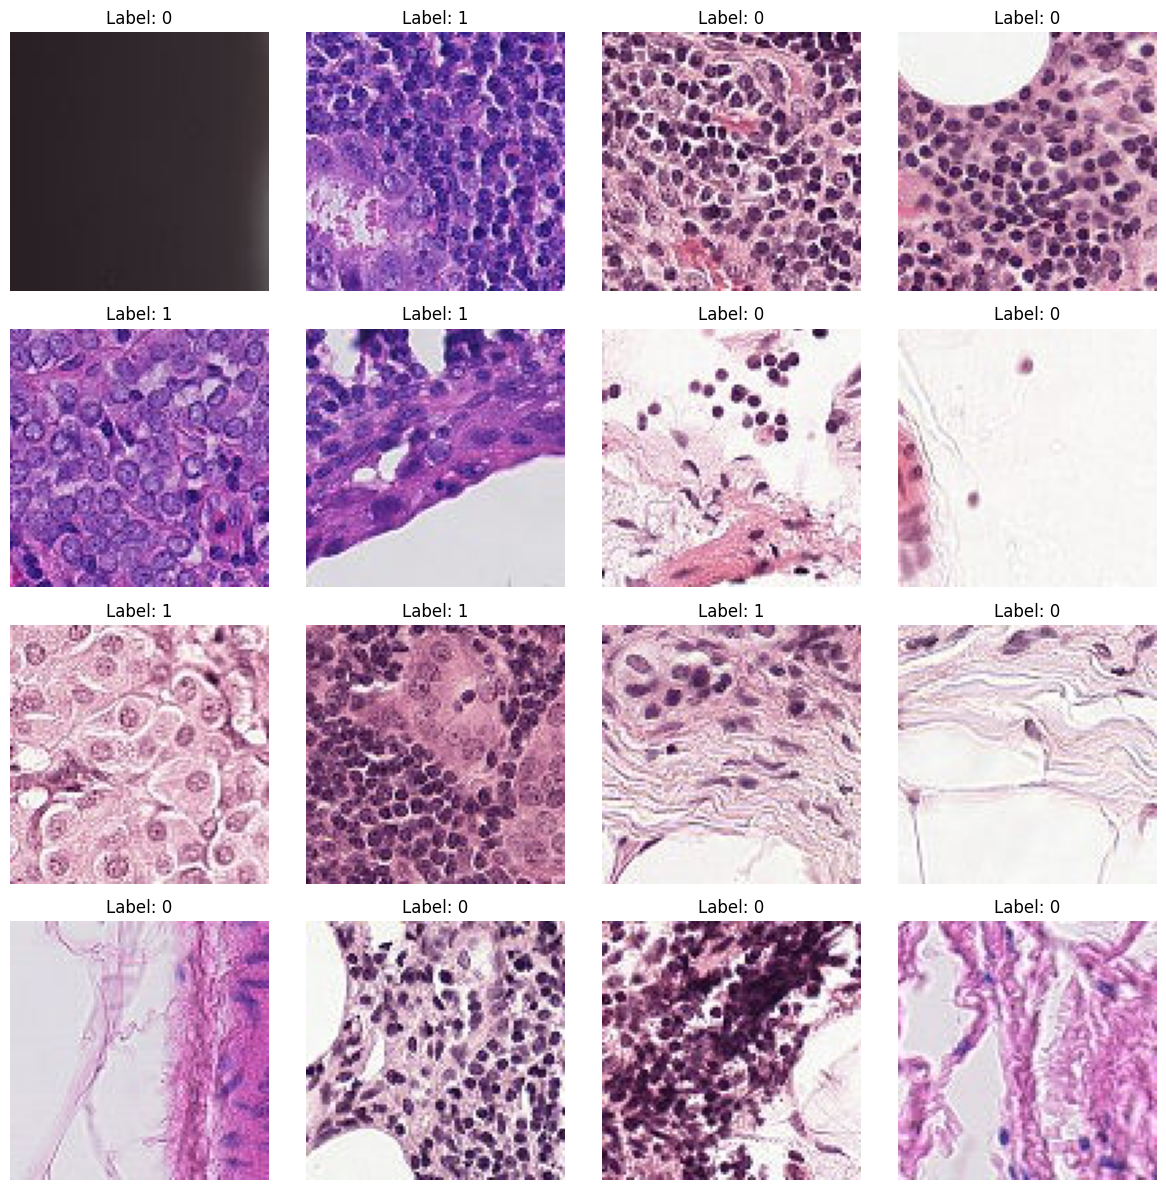

In [4]:
# View some sample images
# Take 16 random images from the DataFrame
sample_rows = labels_df.sample(16, random_state=42)

# Plot them in a 4x4 grid
plt.figure(figsize=(12, 12))
for i, row in enumerate(sample_rows.itertuples()):
    img_path = os.path.join(TRAIN_DIR, row.id + '.tif')
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Label: {row.label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

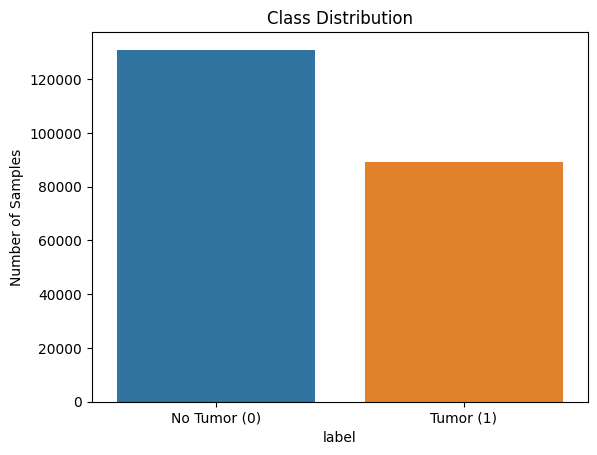

label
0    0.594969
1    0.405031
Name: count, dtype: float64


In [5]:
# What is the class breakdown?
class_counts = labels_df['label'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0, 1], ['No Tumor (0)', 'Tumor (1)'])
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.show()

# Percent breakdown
class_ratio = class_counts / len(labels_df)
print(class_ratio)

# Load and Preprocess Images

In [6]:
# Load and Preprocess images
labels_df['filename'] = labels_df['id'] + '.tif'

train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=44
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 176020
Validation size: 44005


Now we will use Keras utilities to load the images for training in batches and apply some standard preprocessing techniques to them. First, the pixel values in the image will be transformed from a 0-255 range to a 0-1 range (simply divide each value by 255 to scale it). Additionally, in order to create a more robust model we can apply image transformations to the data - rotating, flipping, and shifting - in an attempt to better represent the real/physical world - the presence of a tumor is not dependent on it's position or orientation in 3d space.

Notice that for the validation set, only the re-scaling of pixel values is performed.

In [7]:
# Keras wants string class labels
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Training on the full dataset is not "quick" for the purposes of this learning/practice project
small_df = train_df.sample(n=40000, random_state=42)


# Training set preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=small_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Validation set preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 40000 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Build the Convolutional Neural Network

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753544544.056906      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

The first six layers of this network (Conv2D + MaxPooling2D)x3 are designed to extract features from the images. The next "Flatten" layer will convert the 3D features into a 1D vector, and the subsequent Dense layer is designed to learn complex patterns. Finally there is a dropout layer to help reduce overfitting and an output layer with sigmoid activation function which will produce our binary classification ('0' or '1') label.

# Train the CNN

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753544548.733593      61 service.cc:148] XLA service 0x7f26fc003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753544548.734323      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753544549.061435      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 1:52:26 5s/step - accuracy: 0.3438 - loss: 0.7406

I0000 00:00:1753544551.533057      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 537s 426ms/step - accuracy: 0.7428 - loss: 0.5294 - val_accuracy: 0.7515 - val_loss: 0.5485
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 209s 167ms/step - accuracy: 0.7967 - loss: 0.4559 - val_accuracy: 0.6764 - val_loss: 0.7185
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.8143 - loss: 0.4269 - val_accuracy: 0.8214 - val_loss: 0.4232
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 181s 145ms/step - accuracy: 0.8246 - loss: 0.3998 - val_accuracy: 0.7708 - val_loss: 0.4898
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step - accuracy: 0.8427 - loss: 0.3671 - val_accuracy: 0.7845 - val_loss: 0.4742
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step - accuracy: 0.8465 - loss: 0.3540 - val_accuracy: 0.8385 - val_loss: 0.3822
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step - accuracy: 0.8542 - loss: 0.3431 - val_accuracy: 0.7817 - val_loss: 0.5273
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.8

In [10]:
model.save('/kaggle/working/cancer_cnn_model.h5')

In [11]:
# Load the model from disk
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/cancer_cnn_model.h5')

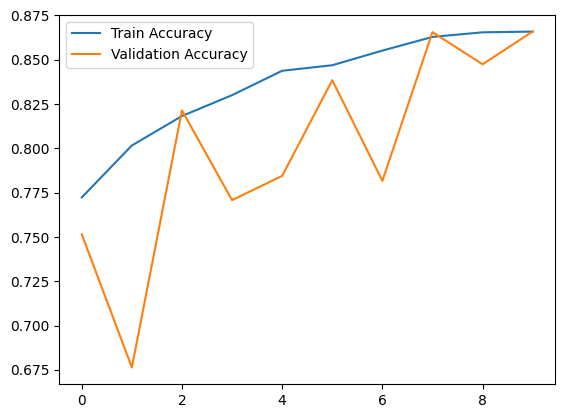

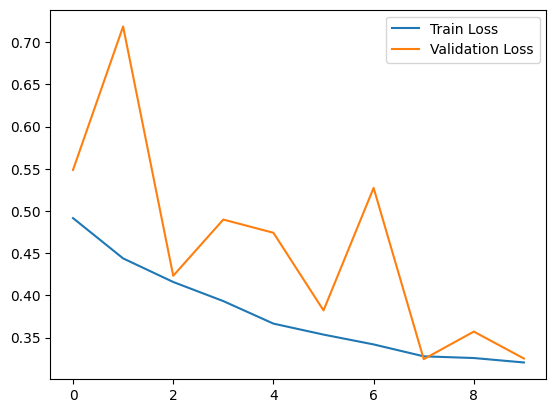

In [12]:
# Examine accuracy and loss during training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [13]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.8660 - loss: 0.3237
Validation Accuracy: 0.8660


In [14]:
# Get true labels and predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
roc_auc = roc_auc_score(y_true, y_pred)
print(f"Validation ROC AUC: {roc_auc:.4f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 53s 38ms/step
Validation ROC AUC: 0.4964


# Predict Test Set

In [15]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
# Create DataFrame with test file names
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({'id': test_filenames})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # a DataFrame with file names from /test
    directory='/kaggle/input/histopathologic-cancer-detection/test',
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

preds = model.predict(test_generator, verbose=1)

# Format submission
submission_df = pd.DataFrame({
    'id': [fname.split('.')[0] for fname in test_generator.filenames],
    'label': preds.flatten()
})

submission_df.to_csv('/kaggle/working/submission.csv', index=False)

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 318s 177ms/step
